# 책보면서 모델링

In [9]:
!pip install gensim

In [ ]:
!pip install konlpy

In [ ]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")
Y_train = np.array([x for x in train['topic_idx']])

# 전처리

In [ ]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한', '하다', '도', '으로']
okt = Okt()

In [ ]:
def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)

  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_sent = [token for token in word_sent if not token in stop_words]
    word_sent = ' '.join(word_sent)
  
  else:
    word_sent = ' '.join(word_sent)
    
  return word_sent


clean_train_title = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_title.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_title.append([])  #string이 아니면 비어있는 값 추가

clean_test_title = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_title.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_title.append([])  #string이 아니면 비어있는 값 추가


In [ ]:
clean_train_title[0]

'인천 핀란드 항공기 결항 휴가 철 여행객 분통'

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_title)
train_sequences = tokenizer.texts_to_sequences(clean_train_title)
test_sequences = tokenizer.texts_to_sequences(clean_test_title)

#word_vocab = tokenizer.word_index # 단어 사전 형태

In [ ]:
print(train_sequences[0])

[366, 4956, 2542, 5249, 1111, 1222, 2769, 8533]


In [ ]:
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0 # 0에대해서 의미없는 단어로 패딩하는것
print(word_vocab)

{'에': 1, '하다': 2, '종합': 3, '서': 4, '로': 5, '일': 6, '도': 7, '명': 8, '대통령': 9, '년': 10, '한국': 11, '으로': 12, '과': 13, '위': 14, '전': 15, '첫': 16, '만': 17, '월': 18, '억원': 19, '적': 20, '삼성': 21, '이란': 22, '되다': 23, '와': 24, '중': 25, '당': 26, '감독': 27, '출시': 28, '천': 29, '장': 30, '경기': 31, '만에': 32, '없다': 33, '게시판': 34, '대': 35, '회': 36, '에서': 37, '트럼프': 38, '보다': 39, '신간': 40, '까지': 41, '문': 42, '제': 43, '원': 44, '개': 45, '안': 46, '자': 47, '정부': 48, '투자': 49, '개발': 50, '분기': 51, '대다': 52, '부터': 53, '지': 54, '서울': 55, '을': 56, '지원': 57, '고': 58, '기': 59, '시': 60, '더': 61, '화': 62, '최고': 63, '중국': 64, '올해': 65, '민주': 66, '조': 67, '내': 68, '개최': 69, '차': 70, '영업': 71, '사': 72, '세계': 73, '현대': 74, '연': 75, '비': 76, '미국': 77, '공개': 78, '최': 79, '기업': 80, '기술': 81, '간': 82, '새': 83, '증권': 84, '코로나': 85, '작년': 86, '신': 87, '대표': 88, '금융': 89, '성': 90, '시장': 91, '다': 92, '있다': 93, '게임': 94, '최대': 95, '억': 96, '상': 97, '김정은': 98, '총리': 99, '속': 100, '북한': 101, '선': 102, '월드컵': 103, '서비스': 104, '사망': 

In [ ]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

In [ ]:
MAX_SEQUENCE_LENGTH = 14 # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
train_labels = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
#test_labels = np.array(test_data['label']) # 테스트 데이터의 라벨

##tfidf로 vectorize

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', sublinear_tf=True, ngram_range=(1, 2), binary=False)

tfidf.fit(clean_train_title)

train_tf_text = tfidf.transform(clean_train_title[:10])
test_tf_text  = tfidf.transform(clean_test_title[:10])

In [ ]:
print(train_tf_text.shape)
print(test_tf_text.shape)

(10, 231707)
(10, 231707)


In [ ]:
tr = train_tf_text.toarray()
te = test_tf_text.toarray()

In [ ]:
tr[0].unique()

AttributeError: ignored

In [ ]:
train_tf_text[0]

<1x150000 sparse matrix of type '<class 'numpy.float32'>'
	with 12 stored elements in Compressed Sparse Row format>

In [ ]:
word_vocab = tfidf.vocabulary_
print(word_vocab)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
len(word_vocab)

150000

In [ ]:
print("전체 단어 개수: ", len(word_vocab))

전체 단어 개수:  26328


In [ ]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

In [ ]:
MAX_SEQUENCE_LENGTH = 14 # 문장 최대 길이

train_inputs = pad_sequences(train_tf_text, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
train_labels = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩

test_inputs = pad_sequences(test_tf_text, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
#test_labels = np.array(test_data['label']) # 테스트 데이터의 라벨

TypeError: ignored

## 다시 모델링

In [ ]:
model_name = 'cnn_kr'
BATCH_SIZE = 256
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LEN = train_inputs.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': data_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.3,
        'hidden_dimension': 250,
        'output_dimension':7}

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [ ]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy(name='accuracy')])

In [ ]:
esc = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

In [ ]:
history = model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks = [esc])

Epoch 1/10
143/143 [==============================] - 14s 84ms/step - loss: 1.2124 - accuracy: 0.0000e+00 - val_loss: 1.1289 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 12s 83ms/step - loss: 0.5358 - accuracy: 0.0000e+00 - val_loss: 0.9615 - val_accuracy: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 12s 83ms/step - loss: 0.3267 - accuracy: 7.8229e-06 - val_loss: 1.1412 - val_accuracy: 0.0000e+00


In [ ]:
test_y = model.predict(test_inputs)

In [ ]:
test_y

array([[5.77521205e-01, 1.81898713e-01, 6.14541769e-01, ...,
        1.44938052e-01, 6.10004961e-02, 3.31260920e-01],
       [8.65444243e-02, 4.62850928e-03, 3.05149794e-01, ...,
        6.27315342e-02, 4.29116488e-02, 4.83619571e-02],
       [1.81755036e-01, 1.14907295e-01, 8.85153174e-01, ...,
        2.40801215e-01, 1.62684917e-02, 9.12363172e-01],
       ...,
       [5.01058400e-02, 2.94546187e-02, 7.18533039e-01, ...,
        9.49561715e-01, 3.79444957e-02, 8.76411498e-02],
       [3.91699970e-01, 8.98219526e-01, 9.76083875e-01, ...,
        5.59157550e-01, 8.53180885e-04, 3.13941836e-01],
       [2.86425054e-02, 1.25342637e-01, 8.32493424e-01, ...,
        8.25373113e-01, 1.57004595e-02, 9.92237449e-01]], dtype=float32)

In [ ]:
topic = []
for i in range(len(test_y)):
    topic.append(np.argmax(test_y[i]))

In [ ]:
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,6
3,45657,3
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,4
9129,54783,2


In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/CNN_스스로.csv', index=False)

# GRU?

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 6.4 MB/s 
     |████████████████████████████████| 448 kB 55.5 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")
Y_train = np.array([x for x in train['topic_idx']])

In [ ]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한', '하다', '도', '으로']
okt = Okt()

In [ ]:
def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)

  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_sent = [token for token in word_sent if not token in stop_words]
    word_sent = ' '.join(word_sent)
  
  else:
    word_sent = ' '.join(word_sent)
    
  return word_sent


clean_train_title = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_title.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_title.append([])  #string이 아니면 비어있는 값 추가

clean_test_title = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_title.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_title.append([])  #string이 아니면 비어있는 값 추가


In [ ]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(clean_train_title)

In [ ]:
# 등장 빈도수가 3회 미만인 단어들의 비중 확인 (2번 이하 = 12990개)
# 1번 등장한 단어들 = 9228개
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26324
등장 빈도가 1번 이하인 희귀 단어의 수: 9228
단어 집합에서 희귀 단어의 비율: 35.05546269563896
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2602135789164297


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17097


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(clean_train_title)
train_sequences = tokenizer.texts_to_sequences(clean_train_title)
test_sequences = tokenizer.texts_to_sequences(clean_test_title)

리뷰의 최대 길이 : 17
리뷰의 평균 길이 : 8.740789416042405


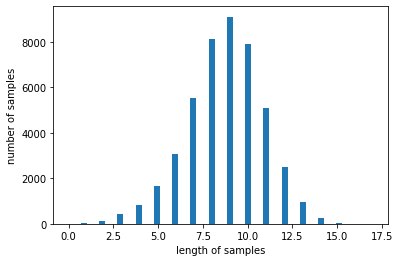

In [ ]:
# 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포 확인
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(l) for l in train_sequences))
print('리뷰의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(s) for s in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 14
below_threshold_len(max_len, train_sequences)

전체 샘플 중 길이가 14 이하인 샘플의 비율: 99.86638629692908


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_data = train_sequences
y_data = train['topic_idx']

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.25, random_state=416, stratify=y_data)

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_test = pad_sequences(test_sequences, maxlen = max_len)
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
#y_train = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩

## 모델링

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 150
VALID_SPLIT = 0.2
MAX_LEN = max_len
dropout_prob = (0.3, 0.7)

In [ ]:
# https://dacon.io/codeshare/2331?dtype=recent
# https://dacon.io/codeshare/2388?dtype=recent

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Flatten, MaxPooling1D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = vocab_size

model1 = Sequential()
model1.add(Embedding(vocab_size, output_dim = 7, input_length = max_len))
model1.add(Bidirectional(GRU(128, activation = "relu", return_sequences = True)))
model1.add(Dropout(dropout_prob[1]))
model1.add(Dense(7, activation = "softmax"))
    
model1.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 7)             119679    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 256)           105216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 256)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 14, 7)             1799      
Total params: 226,694
Trainable params: 226,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('Best_GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model1.fit(X_train, y_train, batch_size = 64, epochs=150, validation_data= (X_valid, y_valid), verbose=2, callbacks=[es, mc])

Epoch 1/150


ValueError: ignored

In [ ]:
test_y = model.predict(test_inputs)
test_y

array([[1.7954232e-01, 4.2515781e-02, 2.3650736e-01, ..., 6.9276780e-02,
        3.7532587e-02, 2.6403641e-02],
       [1.3827609e-03, 2.6294438e-04, 1.7023050e-03, ..., 5.2008277e-04,
        1.6711786e-03, 7.4135751e-05],
       [3.7082054e-02, 1.6961712e-02, 6.1397940e-01, ..., 2.9855659e-02,
        5.4008415e-04, 2.9083577e-01],
       ...,
       [1.2831558e-02, 9.6889408e-03, 8.8524565e-02, ..., 4.1780651e-01,
        3.3310607e-01, 9.6931741e-02],
       [3.0855743e-02, 3.2339054e-01, 5.6499624e-01, ..., 1.3951278e-02,
        1.4098534e-04, 6.5670833e-02],
       [5.5083737e-04, 1.2967210e-03, 2.6348621e-02, ..., 1.3544061e-02,
        7.2718198e-05, 9.5756531e-01]], dtype=float32)

In [ ]:
topic = []
for i in range(len(test_y)):
    topic.append(np.argmax(test_y[i]))

In [ ]:
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,0
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,4
9129,54783,2


In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/GRU_스스로.csv', index=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

embedding_dim = 200  #이게뭐지?
vocab_size = len(word_index) + 1
maxlen = 14
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(Conv1D(128, 7, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# 전처리 새로운 시도

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 47.6 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
!pip install gensim

In [10]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from gensim.models import Doc2Vec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")
Y_train = np.array([x for x in train['topic_idx']])

In [ ]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한', '하다', '도', '으로']
okt = Okt()

In [17]:
def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)

  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_sent = [token for token in word_sent if not token in stop_words]
    word_sent = ' '.join(word_sent)
  
  else:
    word_sent = ' '.join(word_sent)
    
  return word_sent


clean_train_title = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_title.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_title.append([])  #string이 아니면 비어있는 값 추가

clean_test_title = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_title.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_title.append([])  #string이 아니면 비어있는 값 추가


In [18]:
clean_train_title[0]

'인천 핀란드 항공기 결항 휴가 철 여행객 분통'

In [15]:
from tqdm import tqdm
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=4)
model_dbow.build_vocab([x for x in tqdm(clean_train_title)])

100%|██████████| 45654/45654 [00:00<00:00, 1480594.40it/s]


AttributeError: ignored

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_title)

print(tokenizer.word_index)

train_sequences = tokenizer.texts_to_sequences(clean_train_title)
test_sequences = tokenizer.texts_to_sequences(clean_test_title)

{'에': 1, '종합': 2, '서': 3, '로': 4, '일': 5, '명': 6, '대통령': 7, '년': 8, '한국': 9, '과': 10, '위': 11, '전': 12, '첫': 13, '만': 14, '월': 15, '억원': 16, '적': 17, '삼성': 18, '이란': 19, '되다': 20, '와': 21, '중': 22, '당': 23, '감독': 24, '출시': 25, '천': 26, '장': 27, '경기': 28, '만에': 29, '없다': 30, '게시판': 31, '대': 32, '회': 33, '에서': 34, '트럼프': 35, '보다': 36, '신간': 37, '까지': 38, '문': 39, '제': 40, '원': 41, '개': 42, '안': 43, '자': 44, '정부': 45, '투자': 46, '개발': 47, '분기': 48, '대다': 49, '부터': 50, '지': 51, '서울': 52, '을': 53, '지원': 54, '고': 55, '기': 56, '시': 57, '더': 58, '화': 59, '최고': 60, '중국': 61, '올해': 62, '민주': 63, '조': 64, '내': 65, '개최': 66, '차': 67, '영업': 68, '사': 69, '세계': 70, '현대': 71, '연': 72, '비': 73, '미국': 74, '공개': 75, '최': 76, '기업': 77, '기술': 78, '간': 79, '새': 80, '증권': 81, '코로나': 82, '작년': 83, '신': 84, '대표': 85, '금융': 86, '성': 87, '시장': 88, '다': 89, '있다': 90, '게임': 91, '최대': 92, '억': 93, '상': 94, '김정은': 95, '총리': 96, '속': 97, '북한': 98, '선': 99, '월드컵': 100, '서비스': 101, '사망': 102, '전자': 103, '축제': 104, '국내':

In [ ]:
tokenizer.word_counts.items()

odict_items([('인천', 182), ('핀란드', 12), ('항공기', 29), ('결항', 11), ('휴가', 71), ('철', 65), ('여행객', 26), ('분통', 5), ('실리콘밸리', 10), ('넘어서다', 14), ('구글', 184), ('조원', 178), ('들이다', 19), ('전역', 50), ('거점', 21), ('화', 519), ('이란', 856), ('외무', 108), ('긴장', 84), ('완화', 93), ('해결', 116), ('책', 166), ('미국', 462), ('경제', 309), ('전쟁', 157), ('멈추다', 53), ('클린턴', 27), ('측근', 22), ('기업', 451), ('특수', 51), ('관계', 93), ('조명', 62), ('공과', 3), ('사', 477), ('맞다', 323), ('물리다', 9), ('종합', 4056), ('시진핑', 124), ('트럼프', 702), ('에', 7722), ('중미', 13), ('무역', 149), ('협상', 273), ('조속', 14), ('타결', 31), ('희망', 94), ('팔레스타인', 39), ('가자지구', 29), ('서', 2943), ('세', 384), ('소년', 51), ('이스라엘군', 13), ('총격', 77), ('사망', 393), ('인도', 145), ('년', 1631), ('만에', 754), ('파키스탄', 40), ('공습', 67), ('테러', 212), ('캠프', 54), ('폭격', 27), ('대선', 213), ('토론', 47), ('음담패설', 6), ('만회', 6), ('실패', 95), ('사과', 81), ('대신', 127), ('빌다', 17), ('공격', 281), ('역효과', 2), ('푸틴', 88), ('한반도', 127), ('상황', 101), ('진전', 31), ('위', 1204), ('방안', 93), 

In [ ]:
# 등장 빈도수가 3회 미만인 단어들의 비중 확인 (2번 이하 = 12990개)
# 1번 등장한 단어들 = 9228개
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26324
등장 빈도가 1번 이하인 희귀 단어의 수: 9228
단어 집합에서 희귀 단어의 비율: 35.05546269563896
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2602135789164297


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17097


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(clean_train_title)
train_sequences = tokenizer.texts_to_sequences(clean_train_title)
test_sequences = tokenizer.texts_to_sequences(clean_test_title)

In [ ]:
print(train_sequences[:3])

[[363, 4953, 2539, 5246, 1108, 1219, 2766, 8530], [5574, 4412, 354, 374, 3542, 1584, 3282, 59], [19, 700, 928, 823, 649, 406, 74, 159, 437, 1503]]


리뷰의 최대 길이 : 17
리뷰의 평균 길이 : 8.740789416042405


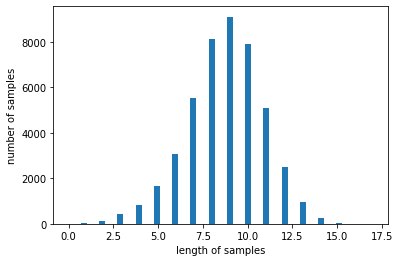

In [ ]:
# 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포 확인
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(l) for l in train_sequences))
print('리뷰의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(s) for s in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 15
below_threshold_len(max_len, train_sequences)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 99.98247689140052


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_data = train_sequences
y_data = train['topic_idx']

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=416, stratify=y_data)

In [ ]:
print(len(X_train))
print(len(X_valid))
print(len(y_train))
print(len(y_valid))

36523
9131
36523
9131


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_test = pad_sequences(test_sequences, maxlen = max_len)
y_train = np_utils.to_categorical(y_train)# y_train 에 원-핫 인코딩
y_valid = np_utils.to_categorical(y_valid)

In [ ]:
X_train

array([[   0,    0,    0, ..., 4716,    6,  102],
       [   0,    0,    0, ...,  113, 1614,  108],
       [   0,    0,    0, ..., 6757, 8552, 5297],
       ...,
       [   0,    0,    0, ...,  781, 1427,  703],
       [   0,    0,    0, ...,  194,    9, 1090],
       [   0,    0,    0, ...,  192, 1905, 1069]], dtype=int32)

In [ ]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## 모델링

### CNN

* 모델링에서 num_filter랑 Kernel_size를 바꾸고 Dropout비율도 조금 수정했었음
* 또한, activation 함수도 softmax가 아닌 sigmoid로 하니 조금 더 높았음
* https://zereight.tistory.com/227 layer들에 대한 설명

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# 하이퍼파라미터 정의

embedding_dim = 128
dropout_prob = (0.4, 0.7)
num_filters = 128

In [ ]:
# 입력 층과 임베딩 층을 정의, 50% 드롭아웃

model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

In [ ]:
# 3, 4, 5의 크기를 가지는 커널을 각각 128개 사용합니다. 그리고 이들을 maxpooling

conv_blocks = []

for sz in [2, 3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

In [ ]:
# maxpooling한 결과를 연결(concatenate) 그리고 이를 밀집 층(dense layer)으로 연결

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(7, activation="softmax")(z)

In [ ]:
model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 128)      2188416     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 15, 128)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 14, 128)      32896       dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)
mc = ModelCheckpoint('Best_CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size = 64, epochs=150, validation_data= (X_valid, y_valid), verbose=2, callbacks=[es, mc])

Epoch 1/150
571/571 - 35s - loss: 1.0669 - acc: 0.6069 - val_loss: 0.5432 - val_acc: 0.8183

Epoch 00001: val_acc improved from -inf to 0.81831, saving model to Best_CNN_model.h5
Epoch 2/150
571/571 - 33s - loss: 0.4702 - acc: 0.8494 - val_loss: 0.5097 - val_acc: 0.8327

Epoch 00002: val_acc improved from 0.81831 to 0.83266, saving model to Best_CNN_model.h5
Epoch 3/150
571/571 - 33s - loss: 0.3317 - acc: 0.8937 - val_loss: 0.5342 - val_acc: 0.8287

Epoch 00003: val_acc did not improve from 0.83266
Epoch 4/150
571/571 - 33s - loss: 0.2537 - acc: 0.9167 - val_loss: 0.5940 - val_acc: 0.8173

Epoch 00004: val_acc did not improve from 0.83266
Epoch 5/150
571/571 - 33s - loss: 0.2113 - acc: 0.9300 - val_loss: 0.6542 - val_acc: 0.8116

Epoch 00005: val_acc did not improve from 0.83266
Epoch 6/150
571/571 - 33s - loss: 0.1695 - acc: 0.9421 - val_loss: 0.7407 - val_acc: 0.8104

Epoch 00006: val_acc did not improve from 0.83266
Epoch 00006: early stopping


In [ ]:
# load weights
model.load_weights("Best_CNN_model.h5")

pred1 = model.predict(X_test)
pred1

In [ ]:
topic = []
for i in range(len(pred1)):
    topic.append(np.argmax(pred1[i]))

In [ ]:
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,2
9129,54783,1


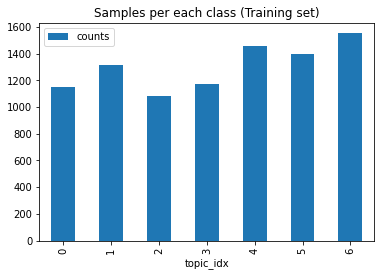

In [ ]:
submission.groupby(submission.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/Multi_Kernel_CNN_v5.csv', index=False)

In [ ]:
submission1 

In [ ]:
#v4 for bestmodel load, kernel size = 2,3,4,5 
#data는 1번 등장한 애들 빼고 사전 구성
#embedding dimension은 128

In [ ]:
# v5  lb_score = 0.8026
#

### SVM

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_test = pad_sequences(test_sequences, maxlen = max_len)
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
#y_train = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split



array([   0,    0,  231, 2834, 5027, 4503,  338,    6, 1135,  542,  564,
          6, 2102,    2], dtype=int32)

### XGB

In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/sample_submission.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/data/topic_dict.csv")
Y_train = np.array([x for x in train['topic_idx']])

In [ ]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한', '하다', '도', '으로']
okt = Okt()

In [ ]:
def clean_text(sent, okt, remove_stopwords = False, stop_words = []):
  sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
  
  word_sent = okt.morphs(sent_clean, stem=True)

  if remove_stopwords:
        
        # 불용어 제거(선택적)
    word_sent = [token for token in word_sent if not token in stop_words]
    word_sent = ' '.join(word_sent)
  
  else:
    word_sent = ' '.join(word_sent)
    
  return word_sent


clean_train_title = []

for review in train['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_title.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_title.append([])  #string이 아니면 비어있는 값 추가

clean_test_title = []

for review in test['title']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_title.append(clean_text(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_title.append([])  #string이 아니면 비어있는 값 추가


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_title)

print(tokenizer.word_index)

{'에': 1, '종합': 2, '서': 3, '로': 4, '일': 5, '명': 6, '대통령': 7, '년': 8, '한국': 9, '과': 10, '위': 11, '전': 12, '첫': 13, '만': 14, '월': 15, '억원': 16, '적': 17, '삼성': 18, '이란': 19, '되다': 20, '와': 21, '중': 22, '당': 23, '감독': 24, '출시': 25, '천': 26, '장': 27, '경기': 28, '만에': 29, '없다': 30, '게시판': 31, '대': 32, '회': 33, '에서': 34, '트럼프': 35, '보다': 36, '신간': 37, '까지': 38, '문': 39, '제': 40, '원': 41, '개': 42, '안': 43, '자': 44, '정부': 45, '투자': 46, '개발': 47, '분기': 48, '대다': 49, '부터': 50, '지': 51, '서울': 52, '을': 53, '지원': 54, '고': 55, '기': 56, '시': 57, '더': 58, '화': 59, '최고': 60, '중국': 61, '올해': 62, '민주': 63, '조': 64, '내': 65, '개최': 66, '차': 67, '영업': 68, '사': 69, '세계': 70, '현대': 71, '연': 72, '비': 73, '미국': 74, '공개': 75, '최': 76, '기업': 77, '기술': 78, '간': 79, '새': 80, '증권': 81, '코로나': 82, '작년': 83, '신': 84, '대표': 85, '금융': 86, '성': 87, '시장': 88, '다': 89, '있다': 90, '게임': 91, '최대': 92, '억': 93, '상': 94, '김정은': 95, '총리': 96, '속': 97, '북한': 98, '선': 99, '월드컵': 100, '서비스': 101, '사망': 102, '전자': 103, '축제': 104, '국내':

In [ ]:
# 등장 빈도수가 3회 미만인 단어들의 비중 확인 (2번 이하 = 12990개)
# 1번 등장한 단어들 = 9228개
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26324
등장 빈도가 1번 이하인 희귀 단어의 수: 9228
단어 집합에서 희귀 단어의 비율: 35.05546269563896
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2602135789164297


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17097


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(clean_train_title)
train_sequences = tokenizer.texts_to_sequences(clean_train_title)
test_sequences = tokenizer.texts_to_sequences(clean_test_title)

리뷰의 최대 길이 : 17
리뷰의 평균 길이 : 8.740789416042405


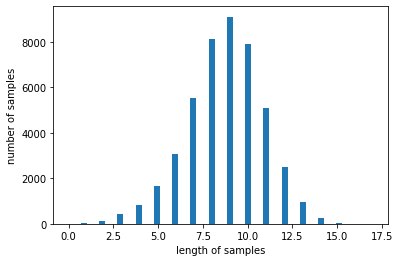

In [ ]:
# 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포 확인
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(l) for l in train_sequences))
print('리뷰의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(s) for s in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 14
below_threshold_len(max_len, train_sequences)

전체 샘플 중 길이가 14 이하인 샘플의 비율: 99.86638629692908


In [ ]:
train_sequences

[[363, 4953, 2539, 5246, 1108, 1219, 2766, 8530],
 [5574, 4412, 354, 374, 3542, 1584, 3282, 59],
 [19, 700, 928, 823, 649, 406, 74, 159, 437, 1503],
 [2694, 3146, 77, 1558, 824, 1285, 11128, 69, 145, 5995, 2],
 [592, 35, 1, 4657, 478, 198, 4413, 2389, 812],
 [1971, 2540, 3, 107, 1559, 4658, 1015, 1, 102],
 [493, 8, 29, 1919, 1189, 301, 1474, 2695, 2],
 [298, 1689, 7693, 7694, 802, 35, 954, 576, 3842, 2694, 193, 13335],
 [881, 577, 749, 2390, 11, 825, 95, 190, 10, 178],
 [867, 7695, 113, 35, 3402, 476, 221, 4414, 184, 17],
 [4000, 3, 483, 1920, 3283, 515, 6977, 185],
 [19, 3, 60, 972, 5575, 468, 2767, 1, 1921, 8, 2151],
 [8531, 104, 36, 219, 772, 4415, 1, 1220, 4954, 3403],
 [3404, 946, 1405, 1880, 301, 203, 44, 783, 73, 43, 113],
 [1839, 62, 727, 1387, 479],
 [13336, 1649, 1001, 48, 204, 7696, 20, 154],
 [294, 1200, 4416, 222, 4, 1650, 198, 3040],
 [304, 189, 1475, 4201, 756, 1, 438, 868],
 [304, 167, 5996, 1072, 193, 909, 735, 10, 791, 19, 1109],
 [13337, 34, 442, 5576, 7697, 5577, 1,

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_data = train_sequences
y_data = train['topic_idx']

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=416, stratify=y_data)

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_test = pad_sequences(test_sequences, maxlen = max_len)
#y_train = np_utils.to_categorical(y_train)
#y_valid = np_utils.to_categorical(y_valid)
#y_train = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩

In [ ]:
X_tr = np.array(X_train)
X_val = np.array(X_valid)
X_tes = np.array(X_test)


In [ ]:
X_val.shape

(9131, 14)

In [ ]:
from xgboost import XGBClassifier

model=XGBClassifier(booster='gbtree', 
                    colsample_bylevel=0.9, 
                    colsample_bytree=0.8, 
                    gamma=0.2, 
                    max_depth=8, 
                    min_child_weight=3, 
                    n_estimators=200, 
                    nthread=4, 
                    objective='multi:softmax', 
                    random_state=416, 
                    silent= False)

model.fit(X_tr,y_train, eval_set=[(X_val,y_valid)],
             early_stopping_rounds=50)





[0]	validation_0-merror:0.731683
Will train until validation_0-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.699814
[2]	validation_0-merror:0.690176
[3]	validation_0-merror:0.67791
[4]	validation_0-merror:0.665754
[5]	validation_0-merror:0.659183
[6]	validation_0-merror:0.64626
[7]	validation_0-merror:0.645274
[8]	validation_0-merror:0.643741
[9]	validation_0-merror:0.640237
[10]	validation_0-merror:0.634542
[11]	validation_0-merror:0.634432
[12]	validation_0-merror:0.633337
[13]	validation_0-merror:0.630161
[14]	validation_0-merror:0.627095
[15]	validation_0-merror:0.620633
[16]	validation_0-merror:0.621181
[17]	validation_0-merror:0.617676
[18]	validation_0-merror:0.61231
[19]	validation_0-merror:0.610996
[20]	validation_0-merror:0.61001
[21]	validation_0-merror:0.608258
[22]	validation_0-merror:0.602891
[23]	validation_0-merror:0.59862
[24]	validation_0-merror:0.598839
[25]	validation_0-merror:0.595992
[26]	validation_0-merror:0.59632
[27]	validation_0-merror:0.5920

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=416,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

In [ ]:
pred = model.predict(X_tes)
pred

array([2, 3, 1, ..., 0, 1, 2])

In [ ]:
topic = []
for i in range(len(pred)):
    topic.append(np.argmax(pred[i]))

In [ ]:
topic = pred
topic

array([2, 3, 1, ..., 0, 1, 2])

In [ ]:
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,2
1,45655,3
2,45656,1
3,45657,4
4,45658,3
...,...,...
9126,54780,3
9127,54781,6
9128,54782,0
9129,54783,1


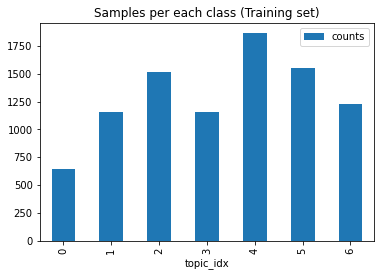

In [ ]:
submission.groupby(submission.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

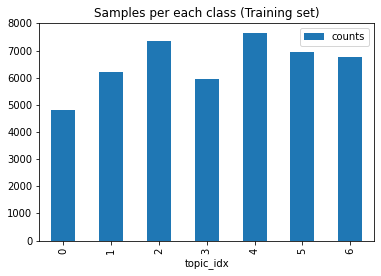

In [ ]:
train['topic_idx'].groupby(train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/XGB_raw.csv', index=False)

#### GridSearch CV

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBClassifier



model=XGBClassifier()
param_grid={'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,3,5],
                 'nthread':[4],
 #                'colsample_bytree':[0.5,0.8],
 #                'colsample_bylevel':[0.5, 0.7, 0.9],
                 'n_estimators':[200],
                 'objective':['multi:softmax']}



In [ ]:
cv=KFold(n_splits=5, shuffle= True, random_state= 416)


gcv=GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=4)


gcv.fit(X_tr,y_train)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
print('best score', gcv.best_score_)      # 최고의 점수

#final params {'booster': 'gbtree', 'gamma': 1, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 200, 'nthread': 4, 'objective': 'multi:softmax', 'silent': True}
#best score 0.5143562918851229

final params {'booster': 'gbtree', 'gamma': 1, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 200, 'nthread': 4, 'objective': 'multi:softmax', 'silent': True}
best score 0.5143562918851229


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_pred)


0.038461538461538464

In [ ]:
# 등장 빈도수가 3회 미만인 단어들의 비중 확인 (2번 이하 = 12990개)
# 1번 등장한 단어들 = 9228개
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(clean_train_title)
train_sequences = tokenizer.texts_to_sequences(clean_train_title)
test_sequences = tokenizer.texts_to_sequences(clean_test_title)

In [ ]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 14
below_threshold_len(max_len, train_sequences)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X_data = train_sequences
y_data = train['topic_idx']

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.25, random_state=416, stratify=y_data)

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_test = pad_sequences(test_sequences, maxlen = max_len)
#y_train = np_utils.to_categorical(y_train)
#y_valid = np_utils.to_categorical(y_valid)
#y_train = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩

In [ ]:
y_train

44045    2
13456    6
32872    3
29409    6
6769     3
        ..
1535     0
30879    6
4138     4
10717    6
4501     6
Name: topic_idx, Length: 34240, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
k_list = range(1,101)
accuracies = []
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(training_data, training_labels)
  accuracies.append(classifier.score(validation_data, validation_labels))
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Breast Cancer Classifier Accuracy")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


def vectorizer(e):
  count_vect = CountVectorizer()
  s = count_vect.fit_transform(e)
  
  # transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
  tfidf_transformer = TfidfTransformer()
  f = tfidf_transformer.fit_transform(s)

  return f



### LSTM-CNN

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_valid = pad_sequences(X_valid, maxlen = max_len)
X_test = pad_sequences(test_sequences, maxlen = max_len)
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)


(36523, 15)
(9131, 15)
(9131, 15)
(36523, 7)
(9131, 7)


In [ ]:
vocab_size = total_cnt+1

embedding_dim = 128


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Concatenate, Flatten
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

* https://wikidocs.net/80437 Conv1D, Maxpooling 설명


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model.add(Dropout(0.3))
model.add(Conv1D(256,
                 kernel_size = 2,
                 padding = 'valid',
                 activation = 'relu',
                 strides = 1))
model.add(MaxPooling1D(pool_size = 4))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.7))
model.add(Dense(7, activation = 'softmax'))
    
model.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics = ['accuracy']) 
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 15, 128)           3369600   
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 14, 256)           65792     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 3, 256)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 7)               

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
mc = ModelCheckpoint('Best_LSTM_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size = 64, epochs=150, validation_data= (X_valid, y_valid), verbose=2, callbacks=[es, mc])

Epoch 1/150
571/571 - 43s - loss: 0.9859 - accuracy: 0.6427 - val_loss: 0.5936 - val_accuracy: 0.8020

Epoch 00001: val_accuracy improved from -inf to 0.80199, saving model to Best_LSTM_model.h5
Epoch 2/150
571/571 - 37s - loss: 0.4516 - accuracy: 0.8552 - val_loss: 0.5785 - val_accuracy: 0.8063

Epoch 00002: val_accuracy improved from 0.80199 to 0.80626, saving model to Best_LSTM_model.h5
Epoch 3/150
571/571 - 37s - loss: 0.2873 - accuracy: 0.9077 - val_loss: 0.6645 - val_accuracy: 0.7975

Epoch 00003: val_accuracy did not improve from 0.80626
Epoch 4/150
571/571 - 36s - loss: 0.1944 - accuracy: 0.9371 - val_loss: 0.7600 - val_accuracy: 0.7910

Epoch 00004: val_accuracy did not improve from 0.80626
Epoch 5/150
571/571 - 36s - loss: 0.1423 - accuracy: 0.9538 - val_loss: 0.8338 - val_accuracy: 0.7816

Epoch 00005: val_accuracy did not improve from 0.80626
Epoch 00005: early stopping


In [ ]:
model.load_weights("Best_LSTM_model.h5")

pred = model.predict(X_test)
pred

array([[1.23819746e-01, 3.05427518e-02, 1.46039784e-01, ...,
        2.58170124e-02, 4.36545089e-02, 6.66970313e-02],
       [1.02469260e-02, 6.46565051e-04, 1.18297469e-02, ...,
        4.09834599e-03, 2.37112213e-03, 1.46029121e-03],
       [5.02609797e-02, 4.99448925e-02, 8.00472915e-01, ...,
        2.97460109e-02, 3.49358050e-03, 4.71015200e-02],
       ...,
       [3.65895443e-02, 1.12556247e-02, 3.49983811e-01, ...,
        2.33942613e-01, 2.47872490e-02, 1.94434803e-02],
       [4.24612351e-02, 5.60159981e-02, 8.54362726e-01, ...,
        2.72320565e-02, 5.07954566e-04, 1.38253868e-02],
       [9.70280729e-03, 4.03599441e-03, 8.20318341e-01, ...,
        4.38457262e-03, 5.33178973e-04, 1.42778188e-01]], dtype=float32)

In [ ]:
topic = []
for i in range(len(pred)):
    topic.append(np.argmax(pred[i]))

In [ ]:
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,2
9129,54783,2


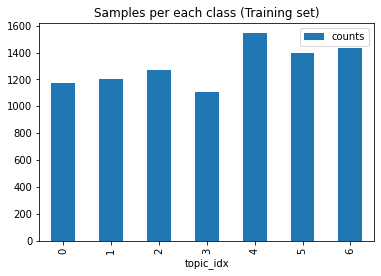

In [ ]:
submission.groupby(submission.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

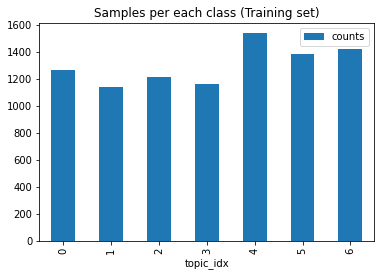

In [ ]:
submission.groupby(submission.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/CNN_LSTM_v4.csv', index=False)

In [ ]:
pred2 = (pred + pred1) /2
pred2

array([[9.28514749e-02, 2.04535890e-02, 1.21182300e-01, ...,
        2.23317798e-02, 2.82733254e-02, 3.71300541e-02],
       [5.29508153e-03, 3.28924682e-04, 6.62644347e-03, ...,
        2.46572914e-03, 1.23212091e-03, 7.32265995e-04],
       [5.79215065e-02, 6.62213117e-02, 7.18566775e-01, ...,
        4.08343375e-02, 4.85457946e-03, 8.81236941e-02],
       ...,
       [2.47058440e-02, 6.35873061e-03, 2.11907566e-01, ...,
        1.39293239e-01, 2.56455429e-02, 1.09325433e-02],
       [8.51916000e-02, 1.10577144e-01, 7.61835933e-01, ...,
        2.92038247e-02, 2.80008360e-04, 9.59051680e-03],
       [7.81010557e-03, 5.49245719e-03, 8.24153244e-01, ...,
        3.79994977e-03, 4.60318290e-04, 1.45376399e-01]], dtype=float32)

In [ ]:
topic = []
for i in range(len(pred2)):
    topic.append(np.argmax(pred2[i]))

In [ ]:
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,3
9129,54783,2


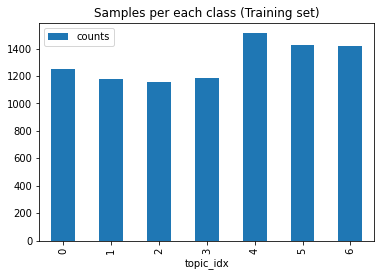

In [ ]:
submission.groupby(submission.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/CNN_LSTM_ens_v1.csv', index=False)

In [ ]:
d1 = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/CNN_LSTM_v3.csv")
d2 = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/CNN_LSTM_v4.csv")
d3 = pd.read_csv("/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/normal_svc.csv")

In [ ]:
d1['topic_idx']

0       2
1       3
2       2
3       2
4       3
       ..
9126    3
9127    2
9128    2
9129    2
9130    2
Name: topic_idx, Length: 9131, dtype: int64

### LSTM-CNN (2)

In [ ]:
vocab_size = vocab_size
embedding_dim = 128


In [ ]:
conv_blocks

[<KerasTensor: shape=(None, 7, 256) dtype=float32 (created by layer 'max_pooling1d_23')>,
 <KerasTensor: shape=(None, 6, 256) dtype=float32 (created by layer 'max_pooling1d_24')>,
 <KerasTensor: shape=(None, 6, 256) dtype=float32 (created by layer 'max_pooling1d_25')>]

In [ ]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(0.4)(z)

conv_blocks = []

for sz in [2, 3, 4]:
    conv = Conv1D(filters = 256,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = MaxPooling1D()(conv)
#    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = LSTM(128,  return_sequences=True)(z)
z = Dropout(0.8)(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(7, activation="softmax")(z)

model.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics = ['accuracy']) 
model.summary()


ValueError: ignored

In [ ]:
model1 = Model(model_input, model_output)
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
model1.summary()

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('Best_LSTM_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model1.fit(X_train, y_train, batch_size = 64, epochs=150, validation_data= (X_valid, y_valid), verbose=2, callbacks=[es, mc])

# 앙상블

In [ ]:
pred1 = pred
pred1

array([[0.6600121 , 0.3295882 , 0.7647376 , ..., 0.24984643, 0.21232286,
        0.3128891 ],
       [0.4288882 , 0.16332003, 0.79292846, ..., 0.24575779, 0.26760393,
        0.17604783],
       [0.5309459 , 0.4841328 , 0.8697245 , ..., 0.38009584, 0.06639385,
        0.52505803],
       ...,
       [0.22523788, 0.04186442, 0.8810078 , ..., 0.9362955 , 0.1303035 ,
        0.23319629],
       [0.9648605 , 0.9188025 , 0.9640599 , ..., 0.4467942 , 0.00238976,
        0.12421885],
       [0.10890871, 0.35368755, 0.95918673, ..., 0.38865498, 0.00420311,
        0.95961154]], dtype=float32)

In [ ]:
pred

array([[2.0261756e-01, 4.6067696e-02, 2.5404659e-01, ..., 1.3616757e-02,
        9.6532153e-03, 3.1274382e-02],
       [1.4996663e-03, 1.8305155e-04, 3.1500582e-03, ..., 4.4701599e-05,
        3.5837194e-04, 3.5789049e-05],
       [4.8251484e-02, 2.9577503e-02, 5.4959130e-01, ..., 4.3556031e-02,
        2.4015659e-03, 2.6553303e-01],
       ...,
       [1.2664807e-01, 1.1383349e-01, 4.3097427e-01, ..., 1.7209360e-01,
        1.4005991e-02, 1.1141701e-02],
       [8.2303956e-02, 1.1453835e-01, 7.8349555e-01, ..., 1.7001996e-02,
        7.5459690e-07, 2.4376106e-03],
       [1.3761574e-03, 3.1213388e-03, 8.5597515e-01, ..., 5.6498828e-03,
        7.5886801e-06, 1.3102441e-01]], dtype=float32)

In [ ]:
pred2 = (pred + pred1)/2
pred2

array([[0.43131483, 0.18782794, 0.5093921 , ..., 0.1317316 , 0.11098804,
        0.17208174],
       [0.21519393, 0.08175154, 0.39803925, ..., 0.12290125, 0.13398115,
        0.08804181],
       [0.2895987 , 0.25685516, 0.7096579 , ..., 0.21182594, 0.03439771,
        0.39529553],
       ...,
       [0.17594297, 0.07784896, 0.655991  , ..., 0.55419457, 0.07215475,
        0.122169  ],
       [0.5235822 , 0.5166704 , 0.87377775, ..., 0.2318981 , 0.00119526,
        0.06332823],
       [0.05514244, 0.17840445, 0.907581  , ..., 0.19715244, 0.00210535,
        0.54531795]], dtype=float32)

In [ ]:
topic = []
for i in range(len(pred2)):
    topic.append(np.argmax(pred2[i]))

In [ ]:
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,2
9129,54783,2


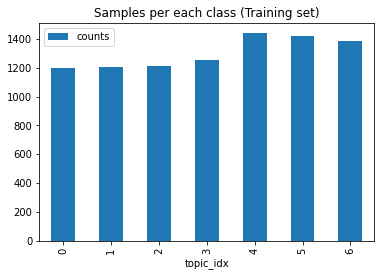

In [ ]:
submission.groupby(submission.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/뉴스 토픽 분류 AI 경진대회/submission/Multi_Kernel_CNN_ensble_v1.csv', index=False)

In [ ]:
# 결론: CNN말고도 머신러닝 + 다른 딥러닝 기법으로 ensenble 하는게 좋겠다